In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.precision', 5)

training = pd.read_csv("../input/train.csv", index_col=0)
test = pd.read_csv("../input/test.csv", index_col=0)

print training.shape
print test.shape

X = training.iloc[:,:-1]
y = training.TARGET

(76020, 370)
(75818, 369)


## XGBClassifier

In [ ]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier(max_depth=6, n_estimators=30, learning_rate=0.3,
                       objective="binary:logistic", gamma=0, min_child_weight=1, max_delta_step=0,
                        subsample=1, colsample_bytree=1, colsample_bylevel=1,
                         reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                         base_score=0.5, seed=0, missing=None)
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", verbose = 0,
        eval_set=[(X_test, y_test)])
        
y_pred = clf.predict(test)

In [ ]:
y_pred = clf.predict_proba(test)
y_pred[:,1]

## Cross Validation with XGBClassifier

In [ ]:
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
"""
clf = xgb.XGBClassifier(max_depth=6, n_estimators=30, learning_rate=0.3,
                       objective="binary:logistic", gamma=0, min_child_weight=1, max_delta_step=0,
                        subsample=1, colsample_bytree=1, colsample_bylevel=1,
                         reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                         base_score=0.5, seed=0, missing=None)
"""

clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=525, 
                        learning_rate=0.02, nthread=4, subsample=0.95, 
                        colsample_bytree=0.85, seed=4242)

res = cross_val_score(clf, X, y, scoring = "roc_auc", cv = 10, n_jobs = 4, verbose = 0)
print "AUC score mean = ", np.mean(res), " +/- ", np.std(res), " = ", np.mean(res) - np.std(res)

In [5]:
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

params = {'n_estimators':[30],
          'learning_rate':[0.1, 0.2, 0.3],
          'max_depth':[6, 8, 10, 12],
          'min_child_weight':[1],
          'max_delta_step':[0],
          'subsample':[1],
          'gamma':[0],
          'colsample_bytree':[1],
          'reg_lambda':[1],
          'reg_alpha':[0], 
          'scale_pos_weight':[1]
         }

clf = xgb.XGBClassifier(objective='binary:logistic',base_score=0.5, seed=0, missing=None)
gs = GridSearchCV(clf, params, cv=5, scoring="roc_auc", verbose= 0, refit=False)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg_alpha': [0], 'scale_pos_weight': [1], 'learning_rate': [0.1, 0.2, 0.3], 'max_delta_step': [0], 'n_estimators': [30], 'colsample_bytree': [1], 'min_child_weight': [1], 'subsample': [1], 'reg_lambda': [1], 'max_depth': [6, 8, 10, 12], 'gamma': [0]},
       pre_dispatch='2*n_jobs', refit=False, scoring='roc_auc', verbose=0)

In [10]:
pd.DataFrame(gs.grid_scores_).iloc[4].parameters

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 30,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1}

## remove std == 0 columns

In [5]:
remove = []
for col in training.columns:
    if training[col].std() == 0:
        remove.append(col)
training.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)
X = training.iloc[:,:-1]
y = training.TARGET

## Xgboost.train

In [6]:
import xgboost as xgb

# Xgboost.train
#params = {"objective": "binary:logistic", "booster": "gbtree", "eval_metric":"auc"}

train_xgb = xgb.DMatrix(X, y)
test_xgb  = xgb.DMatrix(test)

## Part A : Cross Validation

In [13]:
"""
xgboost.train with params
clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, 
                        learning_rate=0.03, nthread=4, subsample=0.95, 
                        colsample_bytree=0.85, seed=4242)
"""
params = {"objective": "binary:logistic", 
          "booster": "gbtree",
          "eta":0.025,
          "gamma":1,
          "max_depth":6,
          "min_child_weight":1,
          "max_delta_step ":0,
          "subsample":0.77,
          "colsample_bytree":0.65,
          "lambda":1,
          "alpha":0,
          "eval_metric":"auc"}

gbm_cv =  xgb.cv(params, train_xgb, num_boost_round=900, nfold=10,
                 as_pandas = True,
                 seed = 42)
gbm_cv = gbm_cv.reset_index()

nrd = gbm_cv['test-auc-mean'].idxmax()
auc_mean_optim = gbm_cv.iloc[nrd]['test-auc-mean']
auc_std_optim = gbm_cv.iloc[nrd]['test-auc-std']
print "| nround = ", nrd, "| test auc mean = ",auc_mean_optim,"| test auc std = ", auc_std_optim

| nround =  309 | test auc mean =  0.8422889 | test auc std =  0.0118551899643


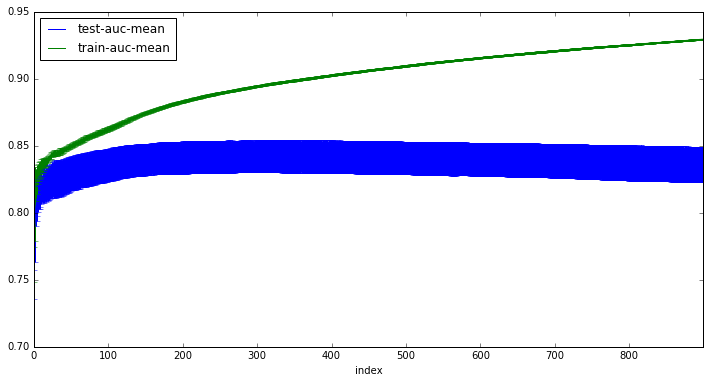

In [14]:
ax = gbm_cv.plot(x = 'index', y = 'test-auc-mean', kind = 'line', yerr = 'test-auc-std')
gbm_cv.plot(x = 'index', y = 'train-auc-mean', kind = 'line', yerr = 'train-auc-std', ax = ax,
           figsize = (12,6))

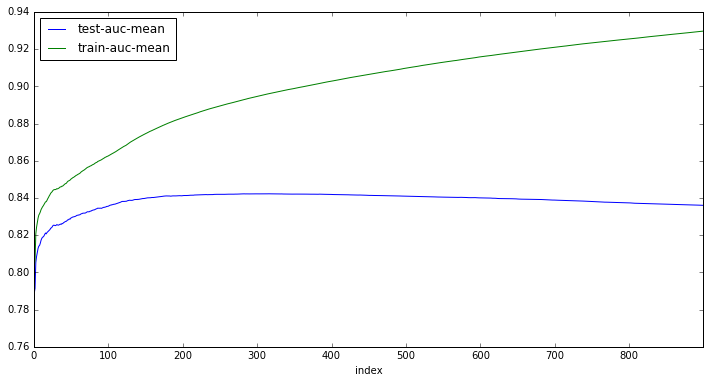

In [15]:
ax = gbm_cv.plot(x = 'index', y = 'test-auc-mean', kind = 'line')
gbm_cv.plot(x = 'index', y = 'train-auc-mean', kind = 'line', ax = ax,
           figsize = (12,6))

## Part B : Submission

In [23]:
gbm = xgb.train(params, train_xgb, num_boost_round= 27, verbose_eval  = 4)
y_pred = gbm.predict(test_xgb)

submission = pd.DataFrame({"ID":test.index, "TARGET":y_pred})
submission.to_csv("../output/mar08_submission.csv", index=False)

## remove columns std == 0

In [ ]:
remove = []
for col in training.columns:
    if training[col].std() == 0:
        remove.append(col)
training.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)
X = training.iloc[:,:-1]
y = training.TARGET

In [ ]:
# Xgboost 
#params = {"objective": "binary:logistic", "booster": "gbtree", "eval_metric":"auc"}

#train_xgb = xgb.DMatrix(X, y)
#test_xgb  = xgb.DMatrix(test)

gbm = xgb.train(params, train_xgb, 20)
y_pred = gbm.predict(test_xgb)

submission = pd.DataFrame({"ID":test.index, "TARGET":y_pred})
submission.to_csv("submission.csv", index=False)

## Xgboost Tuning with xgboost.cv

In [39]:
def xgb_tuning(eta, max_depth):
    params = {"objective": "binary:logistic", 
          "booster": "gbtree",
          "eta": eta,
          "gamma":0,
          "max_depth":max_depth,
          "min_child_weight":1,
          "max_delta_step ":0,
          "subsample":1,
          "colsample_bytree":1,
          "lambda":1,
          "alpha":0,
          "eval_metric":"auc"}

    gbm_cv =  xgb.cv(params, train_xgb, num_boost_round=200, nfold=5,
                 as_pandas = True,
                 seed = 0)
    gbm_cv = gbm_cv.reset_index()

    nrd = gbm_cv['test-auc-mean'].idxmax()
    auc_mean_optim = gbm_cv.iloc[nrd]['test-auc-mean']
    auc_std_optim = gbm_cv.iloc[nrd]['test-auc-std']
    print "eta = ",eta, "| max_depth = ", max_depth, "| nround = ", nrd, "| test auc mean = ",auc_mean_optim,"| test auc std = ", auc_std_optim
    return (eta, max_depth, nrd, auc_mean_optim, auc_std_optim)

In [42]:
etalist = [0.5, 0.1, 0.15, 0.2, 0.25]
max_depthlist = [4, 6, 8, 10, 12, 14, 16, 18]

reslist = []
for eta in etalist:
    for max_depth in max_depthlist:
        res_temp = xgb_tuning(eta, max_depth)
        reslist.append(res_temp)
        
df_res = pd.DataFrame(reslist, columns = ['eta', 'max_depth', 'nround', 'auc_mean','auc_std'])

eta =  0.5 | max_depth =  4 | nround =  12 | test auc mean =  0.8341462 | test auc std =  0.0055649602119
eta =  0.5 | max_depth =  6 | nround =  8 | test auc mean =  0.8330814 | test auc std =  0.00532081161478
eta =  0.5 | max_depth =  8 | nround =  6 | test auc mean =  0.8305728 | test auc std =  0.00708904801507
eta =  0.5 | max_depth =  10 | nround =  4 | test auc mean =  0.825487 | test auc std =  0.00509812848014
eta =  0.5 | max_depth =  12 | nround =  5 | test auc mean =  0.822734 | test auc std =  0.00615888220378
eta =  0.5 | max_depth =  14 | nround =  4 | test auc mean =  0.8183702 | test auc std =  0.0078573302947
eta =  0.5 | max_depth =  16 | nround =  4 | test auc mean =  0.818417 | test auc std =  0.00672237413419
eta =  0.5 | max_depth =  18 | nround =  1 | test auc mean =  0.8150612 | test auc std =  0.00659261214998
eta =  0.1 | max_depth =  4 | nround =  112 | test auc mean =  0.8379158 | test auc std =  0.00475608626499


KeyboardInterrupt: 